## Port Elizabeth Crime Forecasting
### Anil Abraham 2023

#### The goal of this project is to use machine learning techniques to forecast crime in Port Elizabeth. Particularly, forecasting type of crime, number of crimes committed in a year, and crime hotspots.

#### Police stations within Port Elizabeth are:
<ul>
<li>Walmer</li>
<li>Swartkops</li>
<li>Mount Road</li>
<li>Humewood</li>
<li>Kwadwesi</li>
<li>Kabega Park</li>
<li>Algoapark</li>
<li>Gelvandale</li>
<li>Uitenhage</li>
<li>Bethelsdorp</li>
<li>Motherwell</li>
<li>New Brighton</li>
<li>Despatch</li>
<li>Kwazakele</li>
</ul>

### Importing libraries

In [49]:
import pandas as pd #Pandas for data manipulation and analysis
import numpy as np #Numpy for matrices
import geopandas as gpd #Support for geospatial data
from shapely.geometry import Point, Polygon #Geographic information systems functions and analysis
import matplotlib.pyplot as plt #Matplotlib for visualisations
import seaborn as sns
import plotly.express

In [50]:
#sns.set_style("darkgrid")

### Data preprocessing

In [51]:
df = pd.read_csv('crimedata.csv', thousands=',') #Thousands are seperated by commas in the CSV.

print(f'Null values found\n{df.isna().sum()}') #Check for null values

print(f'\n\n{df.columns}') #List all feature names

Null values found
Crime                  0
Crimes                 0
Police Station         0
Province               0
Crime Category         0
Latitude               0
Longitude              0
Latitude, Longitude    0
Year                   0
dtype: int64


Index(['Crime', 'Crimes', 'Police Station', 'Province', 'Crime Category',
       'Latitude', 'Longitude', 'Latitude, Longitude', 'Year'],
      dtype='object')


### What are the datatypes used?

In [52]:
df.dtypes

Crime                   object
Crimes                   int64
Police Station          object
Province                object
Crime Category          object
Latitude               float64
Longitude              float64
Latitude, Longitude     object
Year                     int64
dtype: object

#### What does the csv file look like?

In [53]:
df

,Crime,Crimes,Police Station,Province,Crime Category,Latitude,Longitude,"Latitude, Longitude",Year
0,Murder,5,Aberdeen,Eastern Cape,Contact Crimes,-32.476960,24.060513,"-32.4769604, 24.0605132",2010
1,Attempted murder,3,Aberdeen,Eastern Cape,Contact Crimes,-32.476960,24.060513,"-32.4769604, 24.0605132",2010
2,Assault with the intent to inflict grievous bo...,67,Aberdeen,Eastern Cape,Contact Crimes,-32.476960,24.060513,"-32.4769604, 24.0605132",2010
3,Common assault,31,Aberdeen,Eastern Cape,Contact Crimes,-32.476960,24.060513,"-32.4769604, 24.0605132",2010
4,Common robbery,2,Aberdeen,Eastern Cape,Contact Crimes,-32.476960,24.060513,"-32.4769604, 24.0605132",2010
...,...,...,...,...,...,...,...,...,...
345295,Shoplifting,210,Wynberg,Western Cape,Other Serious Crimes,-34.004107,18.464883,"-34.0041069, 18.4648833",2019
345296,Illegal possession of firearms and ammunition,8,Wynberg,Western Cape,Crime detected as a result of Police Action,-34.004107,18.464883,"-34.0041069, 18.4648833",2019
345297,Drug-related crime,581,Wynberg,Western Cape,Crime detected as a result of Police Action,-34.004107,18.464883,"-34.0041069, 18.4648833",2019
345298,Driving under the influence of alcohol or drugs,252,Wynberg,Western Cape,Crime detected as a result of Police Action,-34.004107,18.464883,"-34.0041069, 18.4648833",2019


#### Limit provinces to only Eastern Cape. After some careful analysis, I found out that there is some incorrect data that has been input. The Police Station 'Doringkloof' does not exist within the Eastern Cape. Doringkloof is a suburb in Gauteng. Therefore, we remove this.

In [54]:
df = df[df['Province'] == 'Eastern Cape']
df = df[df['Police Station'] != 'Doringkloof']

### Limit to police stations in Port Elizabeth only

In [55]:
stations = ["Walmer", "Swartkops", "New Brighton", "Mount Road", "Humewood", "Kwadwesi", "Kabega Park", "Algoapark", "Gelvandale", "Uitenhage", "Bethelsdorp", "Motherwell"
            , "Despatch", "Kwazakele", "Kamesh", "Kwanobuhle", "Ikamvelihle"]
df = df[df['Police Station'].isin(stations)]
df.drop(['Latitude, Longitude', 'Province'], axis=1, inplace=True)
df.reset_index(drop=True, inplace=True)
df.to_csv('PEcrimerates.csv', encoding='utf-8', index=False) #Create new csv file with crime information within PE only

### Let's load the SHP file of South Africa

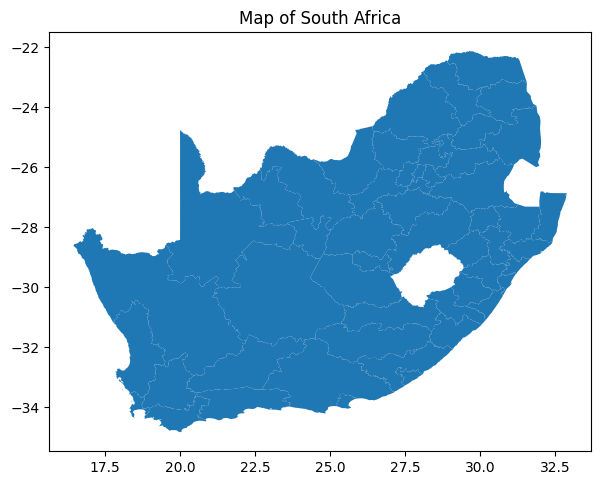

In [56]:
map = gpd.read_file("gadm41_ZAF_shp\\gadm41_ZAF_2.shp")
fig, ax = plt.subplots(figsize=(7,7))
map.plot(aspect=1,ax = ax)
plt.title('Map of South Africa')
plt.show()

### Let's plot the police stations within Port Elizabeth only.

##### But first, group by police station and sum the crimes.

In [57]:
sum_crimes = df.groupby(['Police Station'])['Crimes'].sum()
sum_crimes = sum_crimes.reset_index()
sum_crimes['Latitude'] = df['Latitude'].unique()
sum_crimes['Longitude'] = df['Longitude'].unique()
sum_crimes['size'] = sum_crimes['Crimes'] / 60
    
#A GeoDataFrame is a dataframe that accepts a geometry column (POINT pairs)
geo_df = gpd.GeoDataFrame(sum_crimes, crs = {'init': 'epsg:4326'}, geometry=[Point(xy) for xy in zip(sum_crimes['Longitude'], sum_crimes['Latitude'])])

c:\Users\user-pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



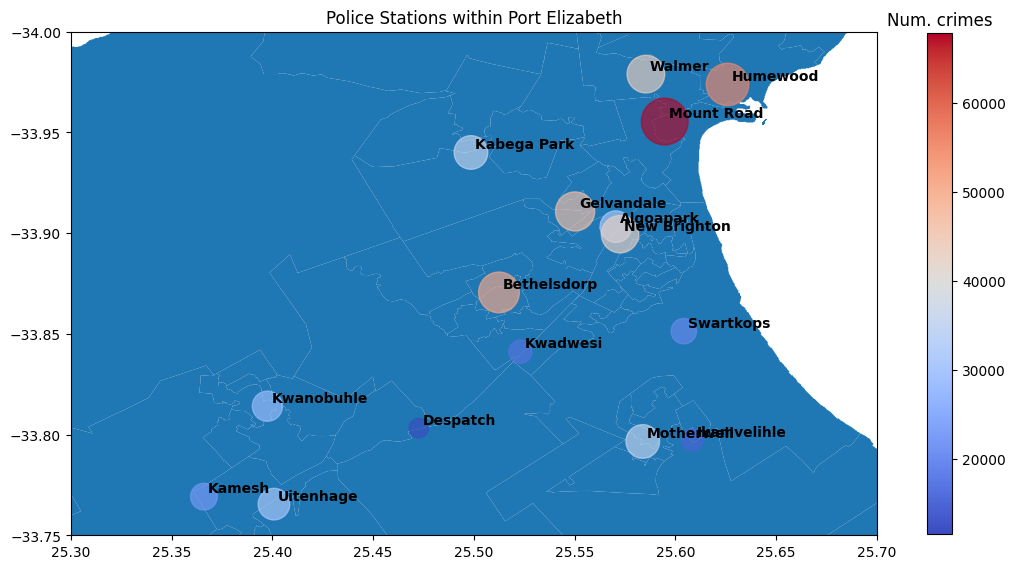

In [77]:
fig, ax = plt.subplots(figsize=(13,13))
map = gpd.read_file("gadm41_ZAF_shp\\gadm41_ZAF_4.shp")
map.plot(ax=ax, aspect=1) #Plot the map of South Africa
geo_df.plot(aspect=1, column='Crimes', ax=ax, markersize='size', cmap='coolwarm', legend=True, alpha=0.65, legend_kwds={'shrink': 0.5}) #Plot the latitude longitude pairs onto the same SA map.
ax.set_ylim([-33.75, -34])
ax.set_xlim([25.3, 25.7])
plt.title('Police Stations within Port Elizabeth')
for x, y, label in zip(geo_df.geometry.x, geo_df.geometry.y, geo_df['Police Station']):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", weight='bold')
ax.get_figure().get_axes()[1].set_title("Num. crimes")
plt.show()

### An interactive map of crime hotspots in PE

In [32]:
import plotly.express as px

fig = px.scatter_mapbox(sum_crimes, lat="Latitude", lon="Longitude", hover_name="Police Station", hover_data=["Crimes"],
                        color="Crimes", color_continuous_scale=['Yellow', 'orange', 'red', 'maroon'], zoom=3, height=600, size='Crimes', size_max=30)
fig.update_layout(mapbox_style="carto-darkmatter")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

<span style="color: #FFFF00">Kwazakele is a police station in Port Elizabeth, but displays outside of PE. What should I do?</span>

In [40]:
geo_df

,Police Station,Crimes,Latitude,Longitude,size,geometry
0,Algoapark,31144,-33.903171,25.570496,0.333333,POINT (25.57050 -33.90317)
1,Bethelsdorp,51610,-33.870520,25.512471,0.233333,POINT (25.51247 -33.87052)
2,Despatch,11619,-33.803171,25.472662,2.633333,POINT (25.47266 -33.80317)
3,Gelvandale,47519,-33.910708,25.550250,6.150000,POINT (25.55025 -33.91071)
4,Humewood,56020,-33.973749,25.625900,0.900000,POINT (25.62590 -33.97375)
5,Ikamvelihle,14836,-33.797272,25.608320,3.933333,POINT (25.60832 -33.79727)
6,Kabega Park,35218,-33.939980,25.498567,1.050000,POINT (25.49857 -33.93998)
7,Kamesh,22196,-33.769185,25.366036,0.166667,POINT (25.36604 -33.76919)
8,Kwadwesi,16837,-33.841086,25.523082,0.050000,POINT (25.52308 -33.84109)
9,Kwanobuhle,28401,-33.814058,25.397537,0.233333,POINT (25.39754 -33.81406)


### Let's do some EDA

In [41]:
df_grouped = df.groupby(['Police Station'])['Crimes'].sum()
df_grouped_year = df.groupby(['Police Station', 'Year'])['Crimes'].sum()

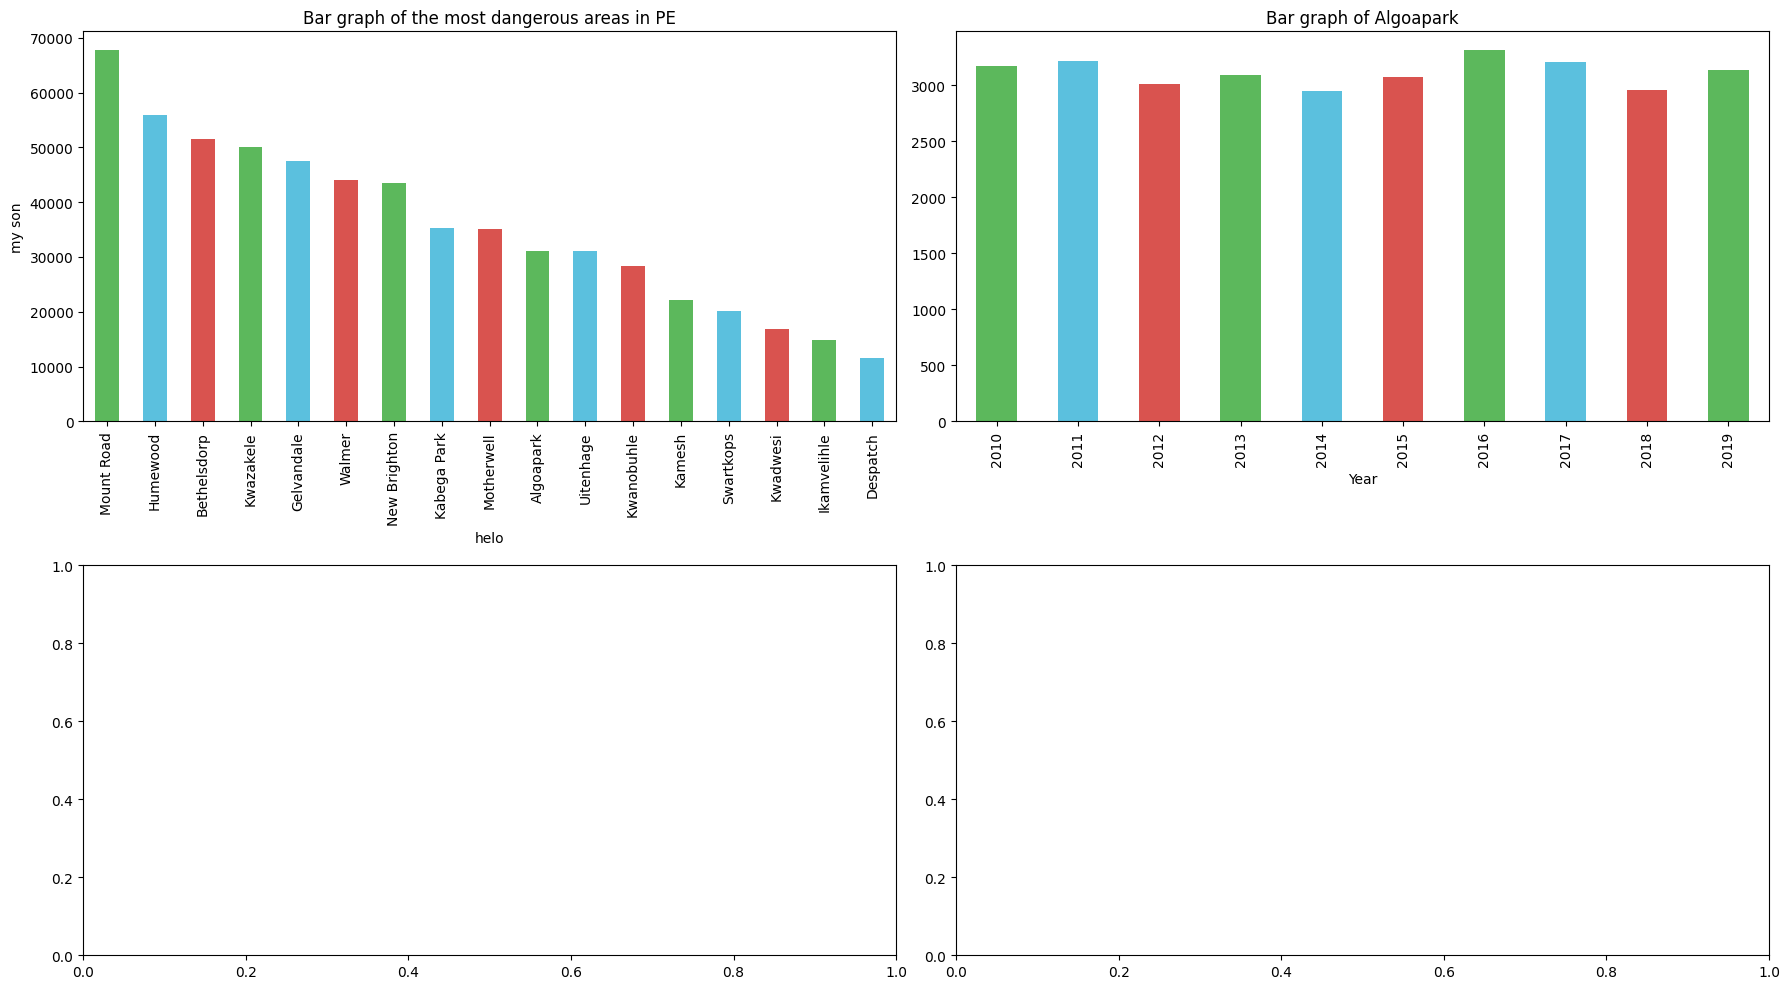

In [42]:
fig, axs = plt.subplots(2, 2, figsize=(18, 10))

df_grouped.sort_values(ascending=False).plot.bar(color=['#5cb85c','#5bc0de','#d9534f'], ax=axs[0,0])
df_grouped_year['Algoapark'].plot.bar(color=['#5cb85c','#5bc0de','#d9534f'], ax=axs[0,1])

axs[0,0].set_title('Bar graph of the most dangerous areas in PE')
axs[0,0].set_xlabel('helo')
axs[0,0].set_ylabel('my son'
                    )
axs[0,1].set_title('Bar graph of Algoapark')
plt.tight_layout()

In [43]:
df_grouped = df_grouped.reset_index()
df_grouped

,Police Station,Crimes
0,Algoapark,31144
1,Bethelsdorp,51610
2,Despatch,11619
3,Gelvandale,47519
4,Humewood,56020
5,Ikamvelihle,14836
6,Kabega Park,35218
7,Kamesh,22196
8,Kwadwesi,16837
9,Kwanobuhle,28401


In [44]:
fig = px.pie(df_grouped, values='Crimes', names='Police Station', title='Pie chart of most dangerous areas in PE')
fig.update_layout(margin=dict(t=70, b=20, l=0, r=0))
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

In [45]:
# fig = px.treemap(df_grouped, values='Crimes', names='Police Station', title='Pie chart of most dangerous areas in PE')
# fig.show()

df['Crime Category'].value_counts().sort_values(ascending=False)

Contact Crimes                                 1020
Aggravated Robbery                             1020
Property-Related Crimes                         850
Sexual Offences                                 680
Crime detected as a result of Police Action     680
Other Serious Crimes                            510
Contact-Related Crimes                          340
Name: Crime Category, dtype: int64

### Thanks for reading!